In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
housing = pd.read_csv('data/housing_train.csv')
housing_test = pd.read_csv('data/housing_test.csv')
#combining train and test data, so that data imputation can be performed on complete set
housing_combined = pd.concat([housing, housing_test], axis=0,ignore_index=True)

## Data Imputation

### Pool Quality and area
There is missing quality for non-zero pool area. Non-zero pool area means house has a pool. We fill the missing quality by looking at median of pool area for a given pool quality

     PoolQC  PoolArea
2420    NaN       368
2503    NaN       444
2599    NaN       561


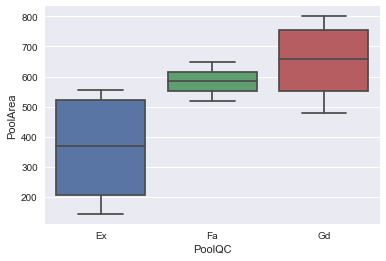

In [3]:
print(housing_combined[( housing_combined['PoolQC'].isnull() == True ) \
                       & (housing_combined['PoolArea'] > 0 )][['PoolQC', 'PoolArea']])
sb.boxplot(x='PoolQC', y='PoolArea', data=housing_combined)


In [4]:
housing_combined.loc[2420,'PoolQC'] = 'Ex'
housing_combined.loc[2503,'PoolQC'] = 'Ex'
housing_combined.loc[2599,'PoolQC'] = 'Fa'

### "Nan means not Present"
All following features are Nan because they are not present at house. We explicity mark them as "None". This is required when we do one-hot encoding of these features and "None" would one such feature for them

In [5]:
housing_combined['Alley'] = housing_combined['Alley'].fillna('None')         
housing_combined['PoolQC'] = housing_combined['PoolQC'].fillna('None')
housing_combined['Fence'] = housing_combined['Fence'].fillna('None')
housing_combined['MiscFeature'] = housing_combined['MiscFeature'].fillna('None')
housing_combined['FireplaceQu'] = housing_combined['FireplaceQu'].fillna('None')

### Electrical
fill missing electrical values with maximum count type

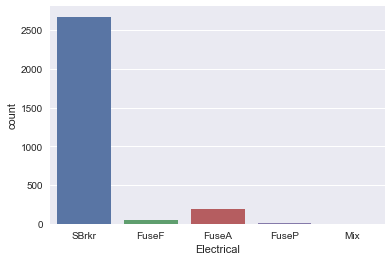

In [6]:
sb.countplot(x='Electrical', data=housing_combined)
housing_combined['Electrical'] = housing_combined['Electrical'].fillna('Sbrkr')

### Garage

In [7]:
#Fill missing Garage year build with build year of house.
housing_combined['GarageYrBlt'] = housing_combined['GarageYrBlt'].fillna(housing_combined['YearBuilt'])

In [8]:
#mark this house without 'GarageCars' as without garage
print(housing_combined[housing_combined['GarageCars'].isnull() == True]\
      [['GarageArea','GarageFinish','GarageCars','GarageType','GarageQual','GarageCond']])
housing_combined.loc[2576,'GarageCars'] = 0
housing_combined.loc[2576,'GarageArea'] = 0

      GarageArea GarageFinish  GarageCars GarageType GarageQual GarageCond
2576         NaN          NaN         NaN     Detchd        NaN        NaN


In [9]:
#update missing values with most common once
print(housing_combined[(housing_combined['GarageFinish'].isnull() == True) & (housing_combined['GarageArea'] > 0)]\
[['GarageArea','GarageFinish','GarageCars','GarageType','GarageQual','GarageCond']])
housing_combined.loc[2126,['GarageQual','GarageCond','GarageFinish']] = ['Gd','TA','RFn']

      GarageArea GarageFinish  GarageCars GarageType GarageQual GarageCond
2126       360.0          NaN         1.0     Detchd        NaN        NaN


In [10]:
#"NA means not Present"
housing_combined['GarageType'] = housing_combined['GarageType'].fillna('None')  
housing_combined['GarageQual']= housing_combined['GarageQual'].fillna('None')
housing_combined['GarageCond']  = housing_combined['GarageCond'].fillna('None')
housing_combined['GarageFinish'] = housing_combined['GarageFinish'].fillna('None')

### MasVnrArea & MasVnrType
Fill missing value with most common one and "NA mean not present"

2610    198.0
Name: MasVnrArea, dtype: float64


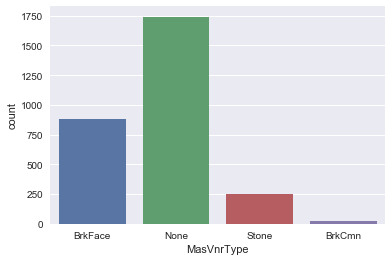

In [11]:
print(housing_combined[(housing_combined['MasVnrArea'].isnull() == False) \
                 & (housing_combined['MasVnrType'].isnull() == True)]['MasVnrArea'])

sb.countplot(housing_combined['MasVnrType'])
housing_combined.loc[2610,'MasVnrType'] = 'BrkCmn'

housing_combined['MasVnrType'] = housing_combined['MasVnrType'].fillna('None')
housing_combined['MasVnrArea'] = housing_combined['MasVnrArea'].fillna(0)

### Lot Frontage
fill missing values of lot frontage by neighbourhood

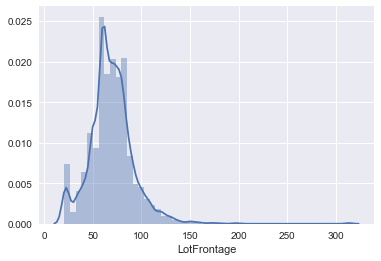

In [12]:
sb.distplot(housing_combined['LotFrontage'].dropna())

lotFrontageByNeighborhood = housing_combined.groupby(['Neighborhood'])['LotFrontage'].mean()
import math

housing_combined['LotFrontage'] = housing_combined.apply(lambda row: \
                                 lotFrontageByNeighborhood[row['Neighborhood']] if math.isnan(row['LotFrontage'])\
                                 else row['LotFrontage'], axis=1)

### Functional, KitchenQual, SaleType, Utilities
fill missing values based on most common once. Droppping Utilities as the whole test data has only AllPub as utilities

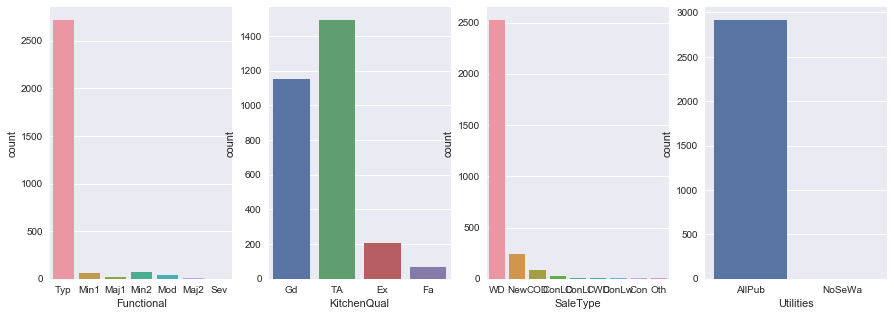

In [13]:
fig, axs = plt.subplots(ncols=4,figsize=(15,5))
sb.countplot(x='Functional', data=housing_combined, ax=axs[0])
sb.countplot(x='KitchenQual', data=housing_combined, ax=axs[1])
sb.countplot(x='SaleType', data=housing_combined, ax=axs[2])
sb.countplot(x='Utilities', data=housing_combined, ax=axs[3])

In [14]:
housing_combined['Functional'].fillna('Typ', inplace=True)
housing_combined['KitchenQual'].fillna('TA', inplace=True)
housing_combined['SaleType'].fillna('WD', inplace=True)
housing_combined.drop(['Utilities'], axis=1, inplace=True)

### Exterior
Values are missing probabaly because Exterior type is not know so filling missing value with 'Other'

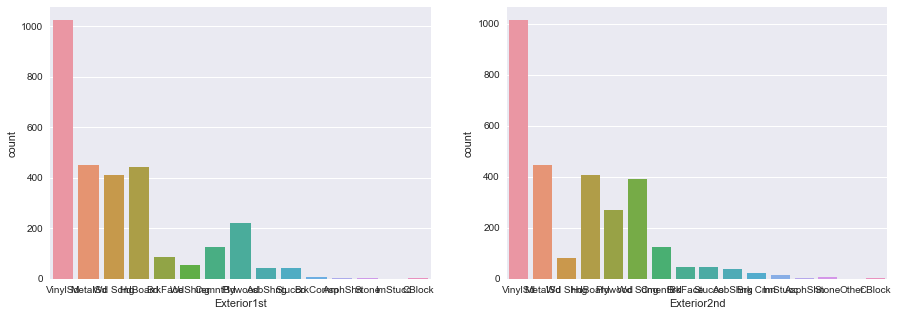

In [15]:
fig, axs = plt.subplots(ncols=2,figsize=(15,5))
sb.countplot(x='Exterior1st', data=housing_combined, ax=axs[0])
sb.countplot(x='Exterior2nd', data=housing_combined, ax=axs[1])

In [16]:
housing_combined['Exterior1st'].fillna('Other', inplace=True)
housing_combined['Exterior2nd'].fillna('Other', inplace=True)

### MSZoning & MSSubClass
filling missing values bassed on MSSubClass

     MSZoning  MSSubClass
1915      NaN          30
2216      NaN          20
2250      NaN          70
2904      NaN          20


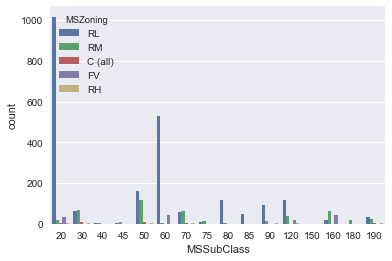

In [17]:
print(housing_combined[housing_combined['MSZoning'].isnull() == True][['MSZoning', 'MSSubClass']])
sb.countplot(housing_combined['MSSubClass'],hue=housing_combined['MSZoning'])

housing_combined.loc[[1915,2250],'MSZoning'] = 'RM'
housing_combined.loc[[2216,2904],'MSZoning'] = 'RL'

### Basement

In [18]:
bsmtCols = housing_combined.columns[housing_combined.columns.str.startswith('Bsmt')]

In [19]:
#missing surface area means no surface area i.e. does not exists in house
housing_combined['BsmtUnfSF'] = housing_combined['BsmtUnfSF'].fillna(0)
housing_combined['TotalBsmtSF'] = housing_combined['TotalBsmtSF'].fillna(0)
housing_combined['BsmtFinSF1'] = housing_combined['BsmtFinSF1'].fillna(0)
housing_combined['BsmtFinSF2'] = housing_combined['BsmtFinSF2'].fillna(0)
housing_combined['BsmtFullBath'] = housing_combined['BsmtFullBath'].fillna(0)
housing_combined['BsmtHalfBath'] = housing_combined['BsmtHalfBath'].fillna(0)

#if surface are is 0 then basement of that type does not exists
housing_combined['BsmtFinType1'] = housing_combined.apply(lambda x : 'None' if x['BsmtFinSF1'] == 0 else x['BsmtFinType1'],axis=1)
housing_combined['BsmtFinType2'] = housing_combined.apply(lambda x : 'None' if x['BsmtFinSF2'] == 0 else x['BsmtFinType2'],axis=1)

#if any of the surface are exists then 'BsmtExposure' is NO otherwise 'None'
housing_combined['BsmtExposure'] = housing_combined.apply(lambda x : 'NO' if x['TotalBsmtSF'] > 0 or x['BsmtFinSF2'] > 0 or x['BsmtFinSF1'] > 0 or x['BsmtUnfSF'] > 0 else 'None',axis=1)

#if no surface are of any type then 'no basement i.e. does not exists in house
housing_combined['BsmtCond'] = housing_combined.apply(lambda x : x['BsmtCond'] if x['TotalBsmtSF'] > 0 or x['BsmtFinSF2'] > 0 or x['BsmtFinSF1'] > 0 or x['BsmtUnfSF'] > 0 else 'None',axis=1)
housing_combined['BsmtQual'] = housing_combined.apply(lambda x : x['BsmtQual'] if x['TotalBsmtSF'] > 0 or x['BsmtFinSF2'] > 0 or x['BsmtFinSF1'] > 0 or x['BsmtUnfSF'] > 0 else 'None',axis=1)



In [20]:
#few more missing values
housing_combined[housing_combined[bsmtCols].isnull().any(axis=1)][bsmtCols]

,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF
332,TA,NO,1124.0,479.0,GLQ,NaN,1.0,0.0,Gd,1603.0
2040,NaN,NO,1044.0,382.0,GLQ,Rec,1.0,0.0,Gd,0.0
2185,NaN,NO,1033.0,0.0,BLQ,None,0.0,1.0,TA,94.0
2217,Fa,NO,0.0,0.0,None,None,0.0,0.0,NaN,173.0
2218,TA,NO,0.0,0.0,None,None,0.0,0.0,NaN,356.0
2524,NaN,NO,755.0,0.0,ALQ,None,0.0,0.0,TA,240.0


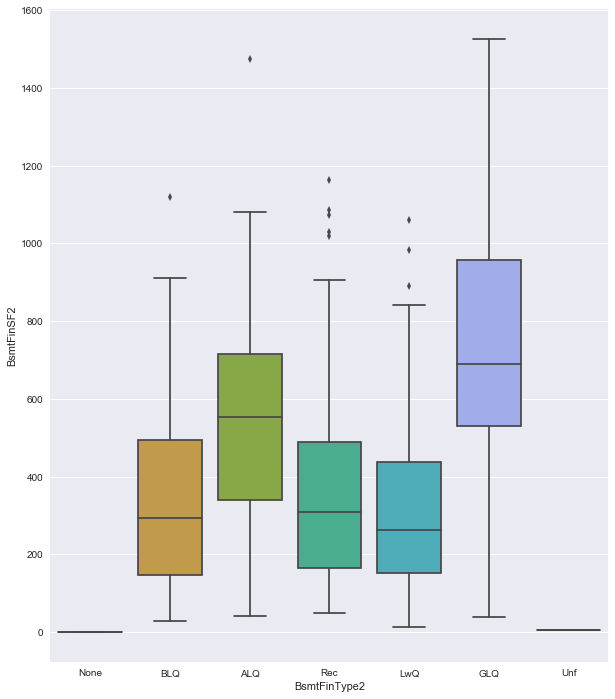

In [21]:
#fill 'BsmtFinType2' based on its surface area
plt.figure(figsize=(10,12))
sb.boxplot(x='BsmtFinType2',y='BsmtFinSF2', data=housing_combined)

housing_combined.loc[332,'BsmtFinType2'] = 'ALQ'

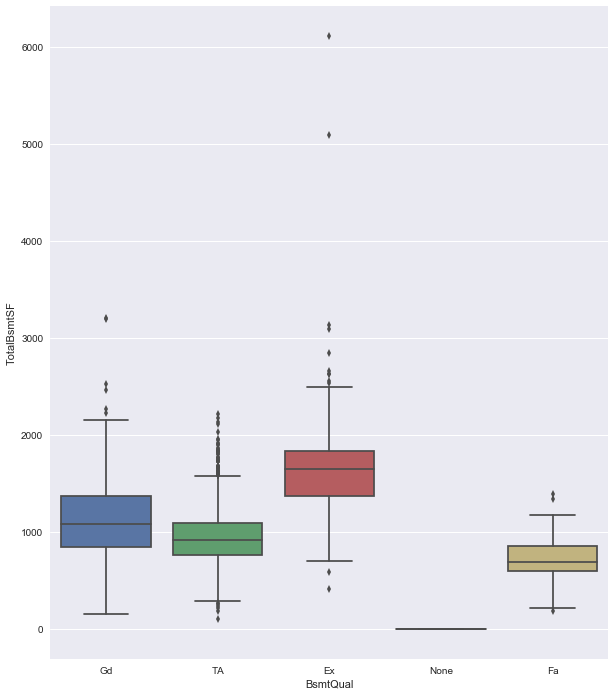

In [22]:
#fill based on Total surface area
plt.figure(figsize=(10,12))
sb.boxplot(x='BsmtQual',y='TotalBsmtSF', data=housing_combined)

housing_combined.loc[2217,'BsmtQual'] = 'Fa'
housing_combined.loc[2218,'BsmtQual'] =  'Fa'

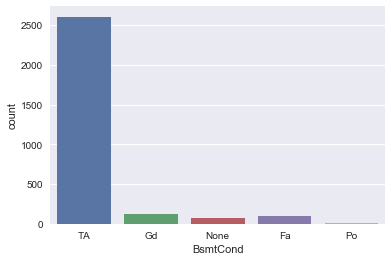

In [23]:
#filled based on most common
sb.countplot(x='BsmtCond', data=housing_combined)

housing_combined.loc[2040,'BsmtCond'] = 'Gd'
housing_combined.loc[2185,'BsmtCond'] = 'Gd'
housing_combined.loc[2524,'BsmtCond'] = 'Po'

In [24]:
#all columns have no null values
housing_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            2919 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2919 non-null object
BsmtExposure     2919 non-null object
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFinType1     2919 non-null object
BsmtFinType2     2919 non-null object
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtQual         2919 non-null object
BsmtUnfSF        2919 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2919 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      29

## Feature Creation

In [25]:
areaCols = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',\
            '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',\
            '3SsnPorch', 'ScreenPorch', 'PoolArea']

### Construction Area

In [26]:
#total buiding surface area
housing_combined['BldSF'] = housing_combined[['TotalBsmtSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF'\
                              , 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']]\
                    .sum(axis=1)

In [27]:
#total construction area
housing_combined['TotalSF'] = housing_combined[['BldSF', 'PoolArea', 'LotFrontage']].sum(axis=1)

### Year and Month of sell

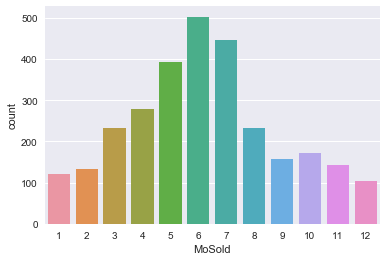

In [28]:
sb.countplot(x='MoSold', data=housing_combined)

In [29]:
housing_combined['HighSeason'] = housing_combined['MoSold'].apply(lambda x: int(x in [5,6,7]))

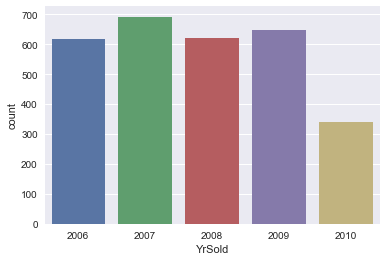

In [30]:
sb.countplot(x='YrSold', data=housing_combined)

In [31]:
housing_combined['LowYear'] = housing_combined['YrSold'].apply(lambda x: int(x == 2010))

### Neighbourhood

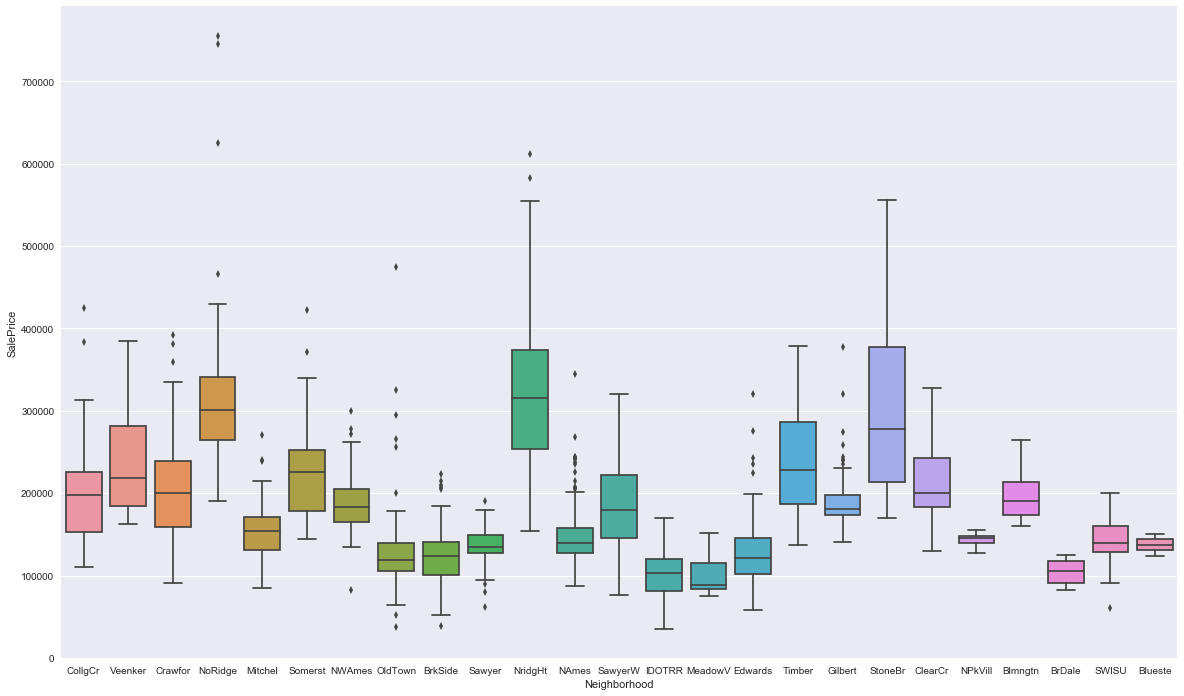

In [32]:
plt.figure(figsize=(20,12))
sb.boxplot(x='Neighborhood', y='SalePrice', data=housing_combined)

In [33]:
housing_combined['RichNeighborhood'] = housing_combined['Neighborhood'].apply(lambda x: int(x in ['NoRidge', 'NridgHt', 'StoneBr']))

From above boxplot we see that median of most of the neighborhood are between 100k to 300k and that where we would have more bins. 

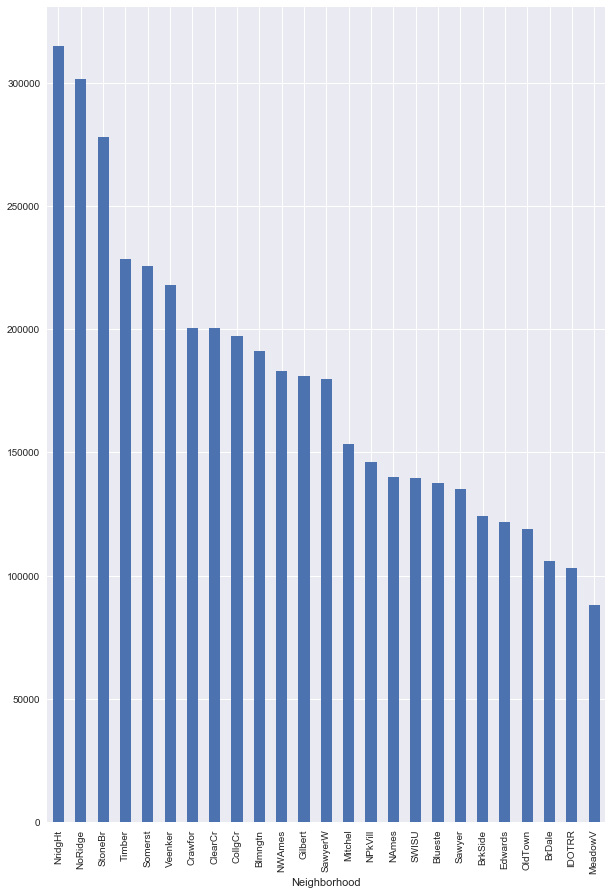

In [34]:
neighborhoodByMedianSalePrice = housing_combined.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False)
plt.figure(figsize=(10,15))
neighborhoodByMedianSalePrice.plot(kind='bar')

In [35]:
mapNeighborhoodBySalePrice = {'MeadowV' : 0, 'IDOTRR' : 1, 'BrDale' : 1, 'OldTown' : 2, 'Edwards' : 2, \
             'BrkSide' : 2, 'Sawyer' : 3, 'Blueste' : 3, 'SWISU' : 3, 'NAmes' : 3, 'NPkVill' : 4, 'Mitchel' : 4, \
             'SawyerW' : 5, 'Gilbert' : 5, 'NWAmes' : 5, 'Blmngtn' : 5, 'CollgCr' : 5, 'ClearCr' : 5, \
             'Crawfor' : 5, 'Veenker' : 6, 'Somerst' : 6, 'Timber' : 6, 'StoneBr' : 7, 'NoRidge' : 7, \
             'NridgHt' : 7}

In [36]:
housing_combined['NeighborhoodBins'] = housing_combined['Neighborhood'].map(mapNeighborhoodBySalePrice)

### House Age

In [37]:
housing_combined['NewHouse'] = (housing_combined['YearBuilt'] == housing_combined['YearRemodAdd']).astype(int)

In [38]:
housing_combined['Age'] = housing_combined['YrSold'] - housing_combined['YearBuilt']
housing_combined['AgeAfterRemodAdd'] = housing_combined['YrSold'] - housing_combined['YearRemodAdd']

### SaleCondition and SaleType

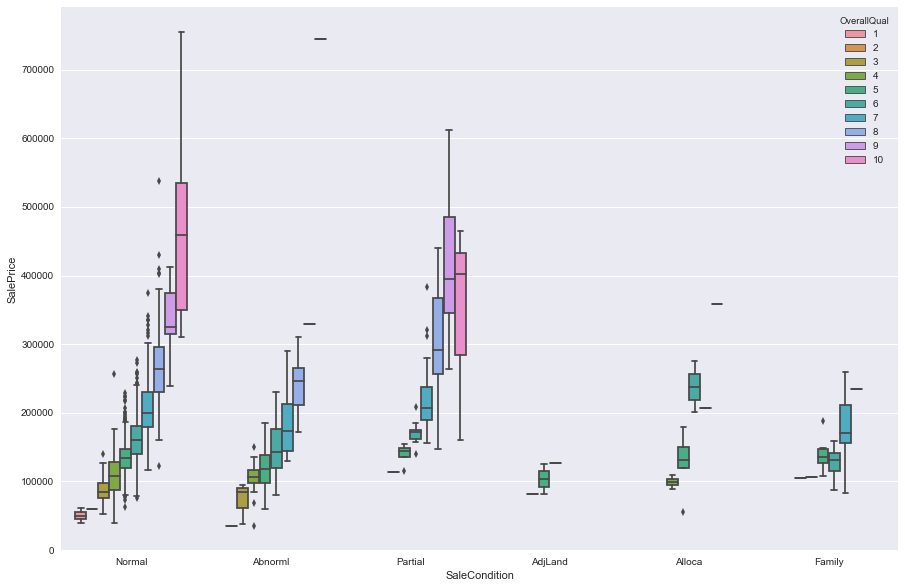

In [39]:
plt.figure(figsize=(15,10))
sb.boxplot(x='SaleCondition', y='SalePrice', data=housing_combined, hue='OverallQual')

In [40]:
#Abnormally sold house are sold for short. Same quality houses are sold for less
housing_combined['ShortSale'] = (housing_combined['SaleCondition'] == 'Abnorml').astype(int)

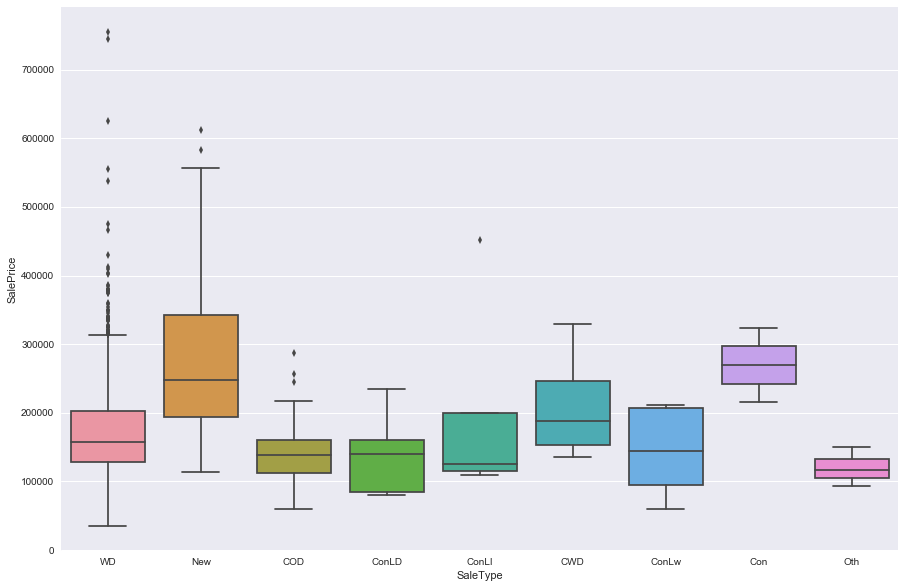

In [41]:
plt.figure(figsize=(15,10))
sb.boxplot(x='SaleType', y='SalePrice', data=housing_combined)

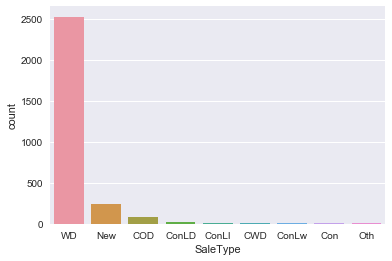

In [42]:
sb.countplot(x='SaleType', data=housing_combined)

In [43]:
#pool is only in train data, no elevator, garage2 and other very few values
housing_combined['Shed'] = (housing_combined['MiscFeature'] == 'Shed').astype(int)

### Converting all quality code to float

In [44]:
qualityCodeMap = {"Ex" : 0, "Gd" :1 , "TA" :2 ,"Fa" :3 ,"Po" :4 ,"None" : 5}
housing_combined['HeatingQC'] = housing_combined['HeatingQC'].map(qualityCodeMap)
housing_combined['ExterQual'] = housing_combined['ExterQual'].map(qualityCodeMap)
housing_combined['ExterCond'] = housing_combined['ExterCond'].map(qualityCodeMap)
housing_combined['BsmtCond'] = housing_combined['BsmtCond'].map(qualityCodeMap)
housing_combined['BsmtQual'] = housing_combined['BsmtQual'].map(qualityCodeMap)
housing_combined['KitchenQual'] = housing_combined['KitchenQual'].map(qualityCodeMap)
housing_combined['FireplaceQu'] = housing_combined['FireplaceQu'].map(qualityCodeMap)
housing_combined['GarageQual'] = housing_combined['GarageQual'].map(qualityCodeMap)
housing_combined['GarageCond'] = housing_combined['GarageCond'].map(qualityCodeMap)
housing_combined['PoolQC'] = housing_combined['PoolQC'].map(qualityCodeMap)

In [45]:
housing_combined.drop(['MoSold', 'YrSold', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'YrSold', \
               'SaleCondition', 'SaleType', 'MiscFeature'], axis=1, inplace=True)

In [46]:
objectColums = housing_combined.dtypes[housing_combined.dtypes == object]
objectColumnDummies = pd.get_dummies(housing_combined[objectColums.index],drop_first=True)

In [47]:
objectColumnDummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 139 entries, Alley_None to Street_Pave
dtypes: float64(139)
memory usage: 3.1 MB


In [48]:
housing_combined = pd.concat([housing_combined,objectColumnDummies],axis=1)

In [49]:
housing_combined.drop(objectColums.index,inplace=True,axis=1)

In [50]:
skew_colums = housing_combined.drop('SalePrice',axis=1).apply(lambda x : x.skew())
skew_colums = skew_colums[skew_colums > 0.75]

In [51]:
housing_combined[skew_colums.index] = housing_combined[skew_colums.index].apply(lambda x: np.log1p(x))

In [52]:
housing_train = housing_combined[:1460]
housing_test = housing_combined[1460:].drop('SalePrice',axis=1)

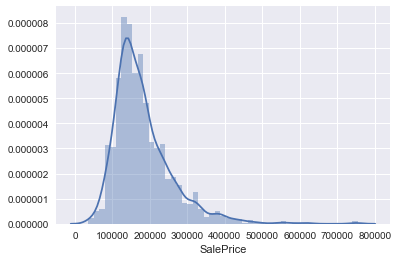

In [53]:
sb.distplot(housing_train['SalePrice'])

In [54]:
housing_train['SalePrice'] = np.log1p(housing_train['SalePrice'])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


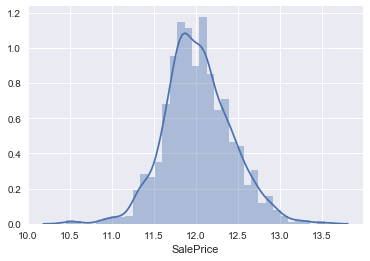

In [55]:
sb.distplot(housing_train['SalePrice'])

## Training
Ridge gave the best results among other linear algos

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

param_grid = {'alpha' : [0.0001,0.001,0.01,0.1,1,10,100,1000]}

pipelineRidge = Pipeline([
    #('select',SelectFromModel(ExtraTreesRegressor(n_estimators=300))),
    ('Scaler', StandardScaler()),
    ('ridge',GridSearchCV(Ridge(), param_grid, cv=5))])

pipelineRidge.fit(housing_train.drop('SalePrice',axis=1), housing_train['SalePrice'])
print('Best score: {}'.format(pipelineRidge.steps[1][1].best_score_))
print('Best parameters: {}'.format(pipelineRidge.steps[1][1].best_params_))

Best score: 0.8858076570809544
Best parameters: {'alpha': 100}


In [57]:
predictRidge = pipelineRidge.predict(housing_test)
predictRidge = np.expm1(predictRidge)
predictRidgedf = pd.DataFrame(predictRidge,columns=['SalePrice'],index=housing_test['Id'])
predictRidgedf.to_csv('TestRidge.csv')

Best score: 0.8858076570809544
